# Logistic Regression Using Features Selected in Random Forest

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from scipy.stats import stats
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
import math

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [2]:
def train_test(df, start_date, split_date):
    training_data = df[df.Date < split_date]

    #remove April 2009 data because there are a lot of nulls
    training_data = training_data[training_data.Date > start_date]

    test_data = df[df.Date > split_date]
    Xtrain = training_data.iloc[:,1:-1]
    #use 2018 season as test data
    Xtest = test_data.iloc[:,1:-1]
    ytrain = training_data.iloc[:,-1]
    ytest = test_data.iloc[:,-1]
    return Xtrain, Xtest, ytrain, ytest

def run_logreg(Xtrain, Xtest, ytrain, ytest, scaler, cw):
    """Fit & tune a Logistic Regression model."""
    Xtrain_scld = scaler.fit_transform(Xtrain)
    Xtest_scld = scaler.transform(Xtest)

    param_grid = {'C': [0.001, 0.1, 1, 10, 100]}
    logreg = LogisticRegression(solver = 'lbfgs', class_weight = cw)
    #cross validation
    logreg_cv = GridSearchCV(logreg, param_grid, cv = 10)
    fitted = logreg_cv.fit(Xtrain_scld, ytrain)
    print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
    print("Best score is {}".format(logreg_cv.best_score_))
    return fitted, Xtrain_scld, Xtest_scld, ytrain, ytest
    
def run_report(fitted, Xtrain_scld, Xtest_scld, ytrain, ytest):
    """Generate Training and Test Classification Reports"""
    ypred = fitted.predict(Xtest_scld)
    ypred_train = fitted.predict(Xtrain_scld)
    
    yprobs = fitted.predict_proba(Xtest_scld)[:,1]
    fpr, tpr, threshold = roc_curve(ytest,  yprobs)
    roc_auc = auc(fpr, tpr)

    print("[Training Classification Report:]")
    print(classification_report(ytrain, ypred_train))
    print('Training Accuracy: ',accuracy_score(ypred_train, ytrain))
    print('')
    print("[Test Classification Report:]")
    print(classification_report(ytest, ypred))
    print('Test Accuracy: ',accuracy_score(ypred, ytest))
    print('')
    print('AUC: ', roc_auc)
    return 

def split_fit_report(df, start_date = '2009-04-30',split_date = '2018-01',scaler = StandardScaler(), cw=None):
    Xtrain, Xtest, ytrain, ytest = train_test(df, start_date, split_date)
    print('')
    fitted, Xtrain_scld, Xtest_scld, ytrain, ytest = run_logreg(Xtrain, Xtest, ytrain, ytest, scaler, cw)
    print('')
    run_report(fitted, Xtrain_scld, Xtest_scld, ytrain, ytest)
    return fitted, Xtrain_scld, Xtest_scld, ytrain, ytest

In [3]:
#for baseline
infile = open('../PickledFiles/gamelogsS09', 'rb')
gamelogsS09 = pickle.load(infile)
infile.close

#list of original relevant columns
infile = open('../PickledFiles/rel_cols', 'rb')
rel_cols = pickle.load(infile)
infile.close

infile = open('../PickledFiles/gamelogsRoll_ext', 'rb')
gamelogsRoll_ext = pickle.load(infile)
infile.close

#
infile = open('../PickledFiles/imp_diffcols_RF', 'rb')
imp_diffcols_RF = pickle.load(infile)
infile.close

#predicted probabilities from RandomForests
infile = open('../PickledFiles/RFprobs', 'rb')
RFprobs = pickle.load(infile)
infile.close

<function BufferedReader.close>

## Logistic Regression Model Using Columns chosen from Random Forest Feat. Importance

In [4]:
fit, Xtrain_scld, Xtest_scld, ytrain, ytest = split_fit_report(gamelogsRoll_ext[imp_diffcols_RF], cw = 'balanced')


Tuned Logistic Regression Parameters: {'C': 1}
Best score is 0.5544002970664687

[Training Classification Report:]
              precision    recall  f1-score   support

           0       0.52      0.56      0.54      9948
           1       0.60      0.56      0.58     11596

   micro avg       0.56      0.56      0.56     21544
   macro avg       0.56      0.56      0.56     21544
weighted avg       0.56      0.56      0.56     21544

Training Accuracy:  0.5588098774600817

[Test Classification Report:]
              precision    recall  f1-score   support

           0       0.56      0.59      0.57      1148
           1       0.61      0.58      0.60      1283

   micro avg       0.58      0.58      0.58      2431
   macro avg       0.58      0.59      0.58      2431
weighted avg       0.59      0.58      0.59      2431

Test Accuracy:  0.5849444672974085

AUC:  0.6119891315269906


This gives us the best results of all the logistic regression models. 

## ROC  Curve

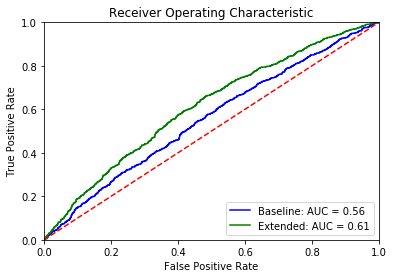

In [5]:
#baseline logistic regression
XtrainBL, XtestBL, ytrainBL, ytestBL = train_test(gamelogsS09[rel_cols], start_date='2009-4-30', split_date='2018-01')
scaler = StandardScaler()
Xtrain_scldBL = scaler.fit_transform(XtrainBL)
Xtest_scldBL = scaler.transform(XtestBL)
logreg = LogisticRegression(solver = 'lbfgs')
fitBL = logreg.fit(Xtrain_scldBL,ytrainBL)
yprobsBL = fitBL.predict_proba(Xtest_scldBL)[:,1]

yprobs = fit.predict_proba(Xtest_scld)[:,1]

fprBL, tprBL, thresholdBL = roc_curve(ytestBL,  yprobsBL)
fpr, tpr, threshold = roc_curve(ytest,  yprobs)
roc_aucBL = auc(fprBL, tprBL)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fprBL, tprBL, 'b', label = 'Baseline: AUC = %0.2f' % roc_aucBL)
plt.plot(fpr, tpr, 'g', label = 'Extended: AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_Curve.png', dpi=300)

In [6]:
#add Logistic Regression predictions to the data frame with the Random Forest predictions
yprobs_LR = fit.predict_proba(Xtest_scld)[:,1]
RFprobs['prob_of_homewin_LR'] = yprobs_LR
RFprobs['pred_LR'] = fit.predict(Xtest_scld)
RFprobs.head()
predsRFandLR = RFprobs

In [7]:
outfile = open('../PickledFiles/RFandLR_preds', 'wb')
pickle.dump(predsRFandLR, outfile)
outfile.close()